In [35]:
pip install pandas numpy matplotlib seaborn openpyxl sqlalchemy pyodbc scikit-learn prophet


Note: you may need to restart the kernel to use updated packages.


In [36]:
import pandas as pd

# ---------- CONFIG ----------
file_path = r"C:\DSEdify_LMS_Analytics\data\raw\LMS_Usage_excel.xlsx"
sheet_to_extract = None  # None = first sheet
output_clean = r"C:\DSEdify_LMS_Analytics\data\processed\lms_usage_cleaned.xlsx"
# ----------------------------

# List all sheets in the Excel file
xls = pd.ExcelFile(file_path)
print("Sheets in file:", xls.sheet_names)

# Load sheet
if sheet_to_extract:
    df = pd.read_excel(file_path, sheet_name=sheet_to_extract)
else:
    df = pd.read_excel(file_path, sheet_name=0)

print("Data loaded successfully. Shape:", df.shape)

Sheets in file: ['Sheet1']
Data loaded successfully. Shape: (10000, 7)


In [37]:
print(df.head())         # First 5 rows
print(df.info())         # Column types and missing data
print(df.describe())     # Numeric summary

  UserID      Techno AccessDate CompletionStatus  Time Spent  Device  Country
0     U0      Python 2024-12-12      In Progress          78  Mobile  Germany
1     U1        Java 2024-12-09        Completed         110  Mobile  Germany
2     U2  JavaScript 2024-05-30        Completed         107  Tablet    India
3     U3         C++ 2025-01-20      In Progress          59  Tablet    India
4     U4          C# 2024-09-04        Completed          73  Mobile   Canada
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   UserID            10000 non-null  object        
 1   Techno            10000 non-null  object        
 2   AccessDate        10000 non-null  datetime64[ns]
 3   CompletionStatus  10000 non-null  object        
 4   Time Spent        10000 non-null  int64         
 5   Device            10000 non-null  object  

In [38]:
from pandas.api.types import is_numeric_dtype, is_datetime64_any_dtype

def column_summary(df):
    summary = []
    for col in df.columns:
        series = df[col]
        dtype = series.dtype
        n_unique = series.nunique(dropna=True)
        n_missing = series.isna().sum()
        sample_unique = series.dropna().unique()[:20].tolist()  # first 20 unique values
        numeric_stats = {}
        if is_numeric_dtype(series):
            numeric_stats = {
                'min': series.min(),
                'max': series.max(),
                'mean': series.mean(),
                'median': series.median(),
                'std': series.std()
            }
        date_range = None
        if is_datetime64_any_dtype(series):
            date_range = (series.min(), series.max())
        summary.append({
            'column': col,
            'dtype': str(dtype),
            'n_unique': n_unique,
            'n_missing': n_missing,
            'sample_unique': sample_unique,
            'numeric_stats': numeric_stats,
            'date_range': date_range
        })
    return pd.DataFrame(summary)

# Convert potential date columns
for c in df.columns:
    if 'date' in c.lower():
        df[c] = pd.to_datetime(df[c], errors='coerce')

summary_df = column_summary(df)
print(summary_df[['column','dtype','n_unique','n_missing','date_range']])

             column           dtype  n_unique  n_missing  \
0            UserID          object     10000          0   
1            Techno          object        30          0   
2        AccessDate  datetime64[ns]       366          0   
3  CompletionStatus          object         3          0   
4        Time Spent           int64       115          0   
5            Device          object         3          0   
6           Country          object         5          0   

                                   date_range  
0                                        None  
1                                        None  
2  (2024-04-29 00:00:00, 2025-04-29 00:00:00)  
3                                        None  
4                                        None  
5                                        None  
6                                        None  


In [39]:
import numpy as np

df_clean = df.copy()

# 1) Trim whitespace from text columns
for c in df_clean.select_dtypes(include='object').columns:
    df_clean[c] = df_clean[c].str.strip()

# 2) Correct known typos in Techno column
corrections = {
    " C#": "C#",
    " 'Ruby": "Ruby",
    "Swif": "Swift",
    "SQL ": "SQL",
    "MongoDB ": "MongoDB",
    "MySQL,": "MySQL"
}
if 'Techno' in df_clean.columns:
    df_clean['Techno'] = df_clean['Techno'].replace(corrections)

# 3) Ensure numeric columns
df_clean['Time Spent'] = pd.to_numeric(df_clean['Time Spent'], errors='coerce')

# 4) Ensure AccessDate is datetime
df_clean['AccessDate'] = pd.to_datetime(df_clean['AccessDate'], errors='coerce')

# 5) Remove duplicate rows
df_clean = df_clean.drop_duplicates()

# 6) Add derived column for month
df_clean['AccessMonth'] = df_clean['AccessDate'].dt.to_period('M').astype(str)

# Save snapshot for next steps
df_clean.to_csv(output_clean, index=False)
print("Cleaned data saved to:", output_clean)

Cleaned data saved to: C:\DSEdify_LMS_Analytics\data\processed\lms_usage_cleaned.xlsx


In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load cleaned CSV
file_clean = r"C:\DSEdify_LMS_Analytics\data\processed\lms_usage_cleaned.xlsx"
df = pd.read_csv(file_clean, parse_dates=['AccessDate'])

print("Shape:", df.shape)
print(df.head())

Shape: (10000, 8)
  UserID      Techno AccessDate CompletionStatus  Time Spent  Device  Country  \
0     U0      Python 2024-12-12      In Progress          78  Mobile  Germany   
1     U1        Java 2024-12-09        Completed         110  Mobile  Germany   
2     U2  JavaScript 2024-05-30        Completed         107  Tablet    India   
3     U3         C++ 2025-01-20      In Progress          59  Tablet    India   
4     U4          C# 2024-09-04        Completed          73  Mobile   Canada   

  AccessMonth  
0     2024-12  
1     2024-12  
2     2024-05  
3     2025-01  
4     2024-09  


In [41]:
# Set Seaborn theme
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12,7)
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

C:\Users\varsh\AppData\Local\Temp\ipykernel_20568\915817285.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=user_counts.values, y=user_counts.index, palette="viridis")


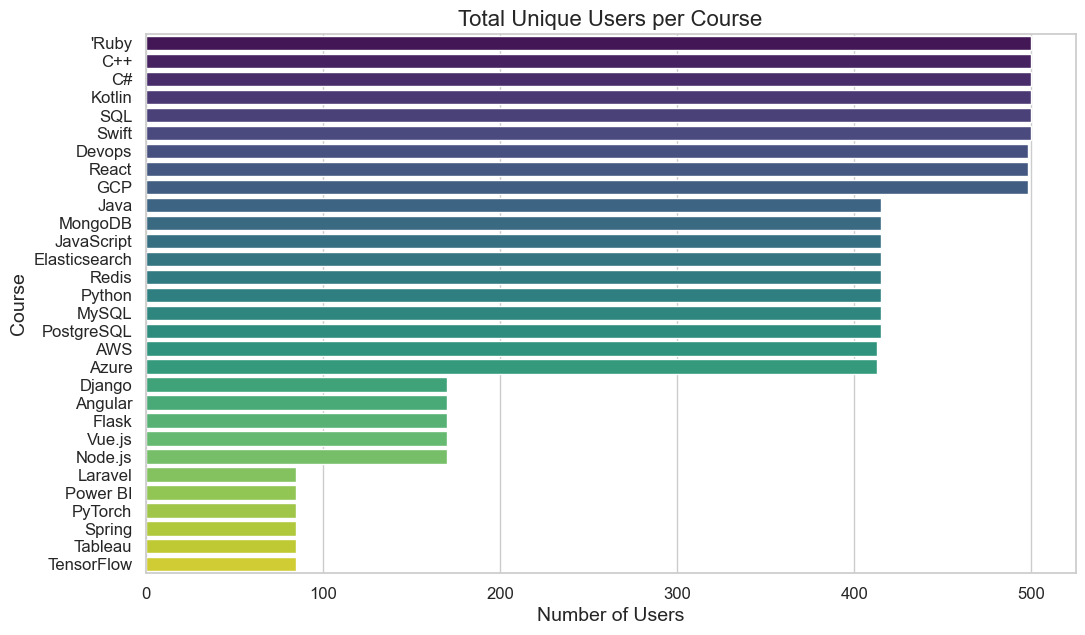

In [42]:
user_counts = df.groupby('Techno')['UserID'].nunique().sort_values(ascending=False)
sns.barplot(x=user_counts.values, y=user_counts.index, palette="viridis")
plt.title("Total Unique Users per Course")
plt.xlabel("Number of Users")
plt.ylabel("Course")
plt.show()


C:\Users\varsh\AppData\Local\Temp\ipykernel_20568\3964548673.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_time.values, y=avg_time.index, palette="mako")


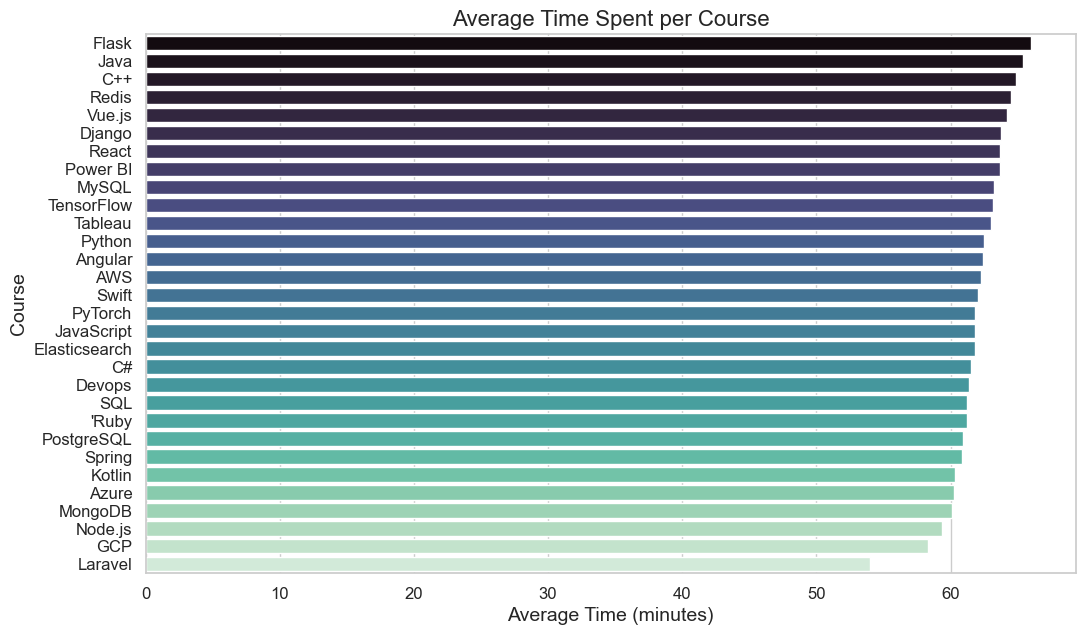

In [43]:
avg_time = df.groupby('Techno')['Time Spent'].mean().sort_values(ascending=False)
sns.barplot(x=avg_time.values, y=avg_time.index, palette="mako")
plt.title("Average Time Spent per Course")
plt.xlabel("Average Time (minutes)")
plt.ylabel("Course")
plt.show()

In [44]:
completion_stats = df.groupby('Techno')['CompletionStatus'].value_counts().unstack(fill_value=0)
completion_stats['CompletionRate%'] = (completion_stats.get('Completed',0)/completion_stats.sum(axis=1))*100

completion_stats = completion_stats.sort_values('CompletionRate%', ascending=False)
print(completion_stats[['Completed','In Progress','Not Started','CompletionRate%']])

CompletionStatus  Completed  In Progress  Not Started  CompletionRate%
Techno                                                                
PyTorch                  48           22           15        56.470588
Vue.js                   92           44           34        54.117647
AWS                     219          118           76        53.026634
PostgreSQL              220          119           76        53.012048
Elasticsearch           220          108           87        53.012048
C++                     265          146           89        53.000000
Node.js                  89           53           28        52.352941
GCP                     260          151           87        52.208835
MySQL                   216          123           76        52.048193
Java                    215          113           87        51.807229
Angular                  88           51           31        51.764706
Python                  214          132           69        51.566265
Devops

C:\Users\varsh\AppData\Local\Temp\ipykernel_20568\1096238120.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=completion_counts.index, y=completion_counts.values, palette="coolwarm")


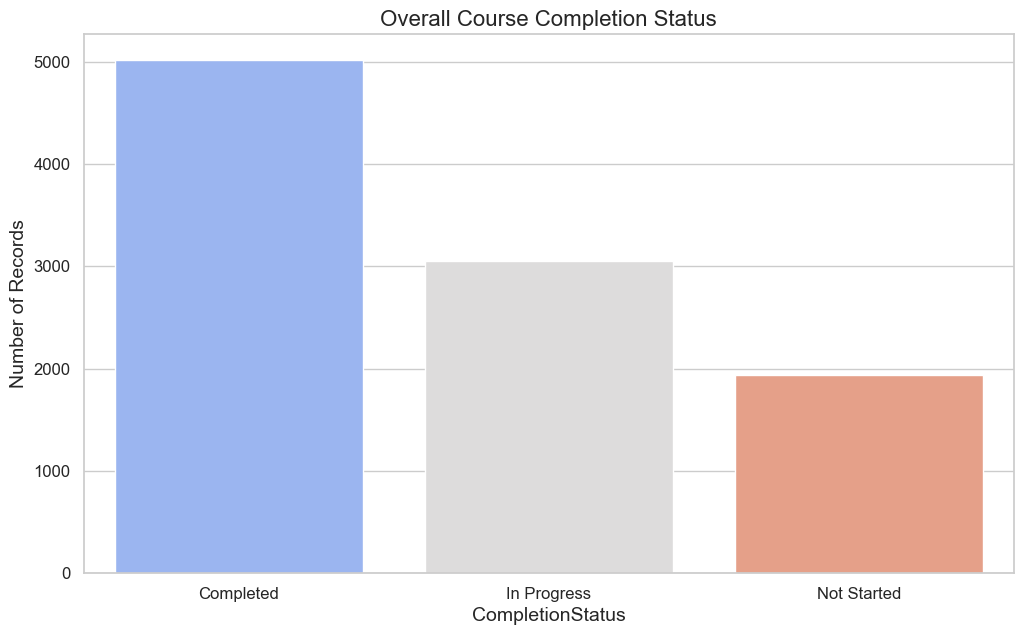

In [45]:
completion_counts = df['CompletionStatus'].value_counts()
sns.barplot(x=completion_counts.index, y=completion_counts.values, palette="coolwarm")
plt.title("Overall Course Completion Status")
plt.ylabel("Number of Records")
plt.show()

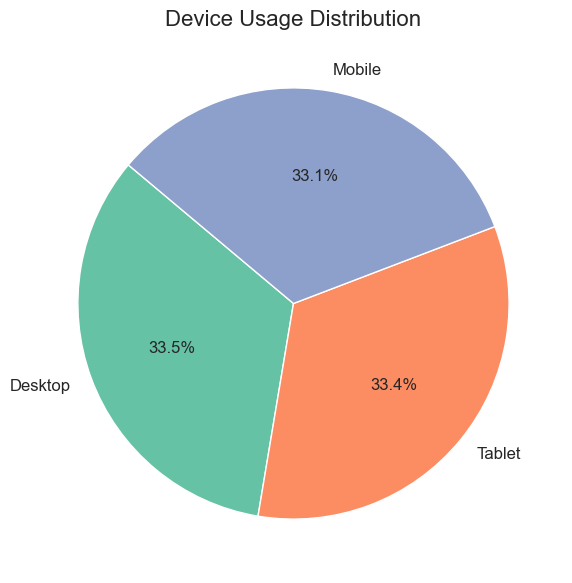

In [46]:
device_counts = df['Device'].value_counts()
plt.pie(device_counts, labels=device_counts.index, autopct='%1.1f%%', colors=sns.color_palette("Set2"), startangle=140)
plt.title("Device Usage Distribution")
plt.show()

C:\Users\varsh\AppData\Local\Temp\ipykernel_20568\926392335.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=country_counts.index, y=country_counts.values, palette="pastel")


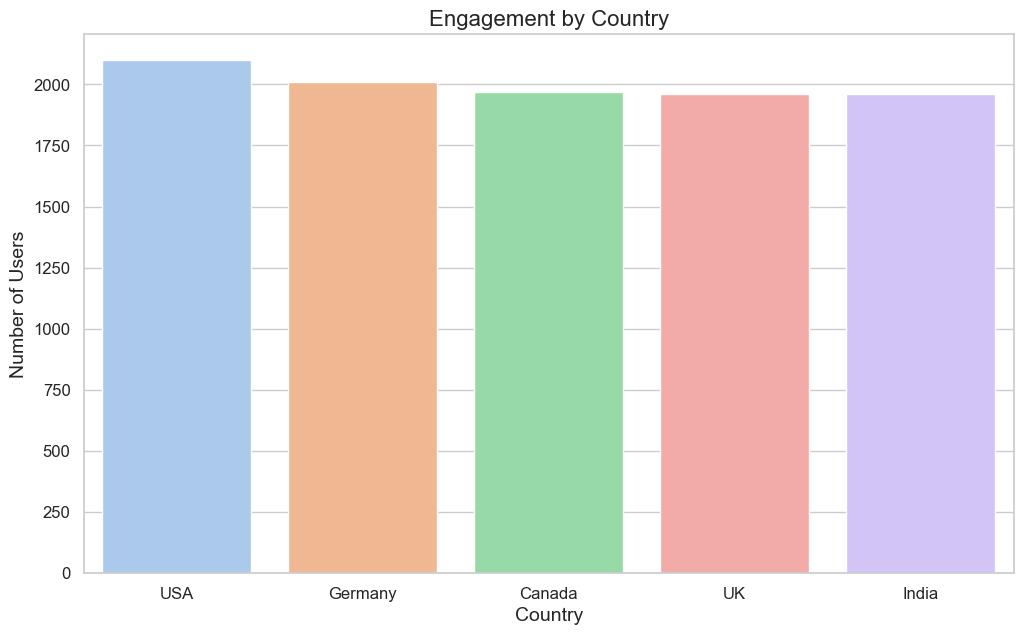

In [47]:
country_counts = df['Country'].value_counts()
sns.barplot(x=country_counts.index, y=country_counts.values, palette="pastel")
plt.title("Engagement by Country")
plt.ylabel("Number of Users")
plt.show()

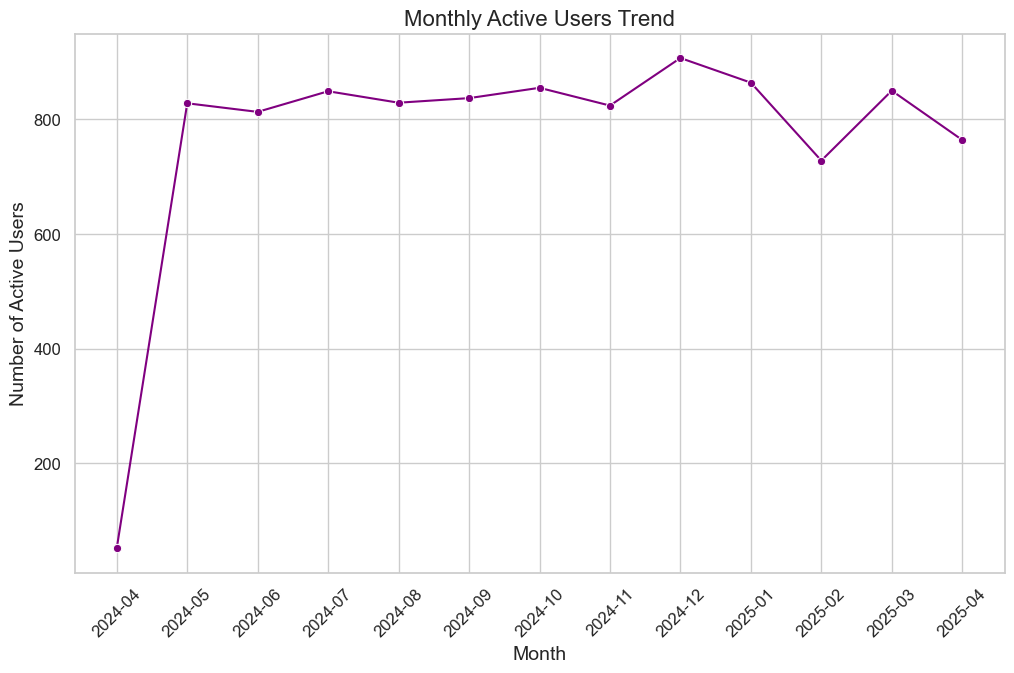

In [48]:
# Ensure AccessDate is datetime
df['AccessDate'] = pd.to_datetime(df['AccessDate'])

# Create a new column for month (you can use month number or YYYY-MM format)
df['AccessMonth'] = df['AccessDate'].dt.to_period('M')  # '2025-03' format

# Now you can group by AccessMonth
monthly_access = df.groupby('AccessMonth')['UserID'].nunique()

# Plot
import seaborn as sns
import matplotlib.pyplot as plt

sns.lineplot(x=monthly_access.index.astype(str), y=monthly_access.values, marker='o', color='purple')
plt.title("Monthly Active Users Trend")
plt.xlabel("Month")
plt.ylabel("Number of Active Users")
plt.xticks(rotation=45)
plt.show()


In [49]:
df.to_csv(r"C:\DSEdify_LMS_Analytics\data\processed\lms_usage_tableau_ready.xlsx", index=False)
# Aggregate example for SQL / Tableau
agg_course = df.groupby('Techno').agg(
    Users=('UserID','nunique'),
    AvgTime=('Time Spent','mean'),
    Completed=('CompletionStatus', lambda x: (x=='Completed').sum()),
    InProgress=('CompletionStatus', lambda x: (x=='In Progress').sum()),
    NotStarted=('CompletionStatus', lambda x: (x=='Not Started').sum())
).reset_index()

agg_course.to_csv(r"C:\DSEdify_LMS_Analytics\data\processed\lms_usage_agg.xlsx", index=False)

In [1]:
pip install pyodbc pandas matplotlib seaborn openpyxl

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pyodbc
import pandas as pd

# Database connection
conn = pyodbc.connect(
    'Driver={SQL Server};'
    'Server=VARSHA\\MSSQL;'   # your server name
    'Database=LMSAnalytics;'
    'Trusted_Connection=yes;'
)

print("✅ Connection Successful!")


✅ Connection Successful!


In [3]:
# Load full table
query = "SELECT * FROM dbo.LMS_Usage"
df = pd.read_sql(query, conn)

# Check top 5 rows
print(df.head())

# Check shape (rows × columns)
print("Total rows and columns:", df.shape)


  UserID      Techno AccessDate CompletionStatus  Time_Spent  Device  Country  \
0     U0      Python 2024-12-12      In Progress          78  Mobile  Germany   
1     U1        Java 2024-12-09        Completed         110  Mobile  Germany   
2     U2  JavaScript 2024-05-30        Completed         107  Tablet    India   
3     U3         C++ 2025-01-20      In Progress          59  Tablet    India   
4     U4          C# 2024-09-04        Completed          73  Mobile   Canada   

  AccessMonth  
0     2024-12  
1     2024-12  
2     2024-05  
3     2025-01  
4     2024-09  
Total rows and columns: (10000, 8)


C:\Users\varsh\AppData\Local\Temp\ipykernel_27560\1538921448.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


In [4]:
# Check data info
print(df.info())

# Summary statistics
print(df.describe())

# Count missing values
print(df.isnull().sum())

# Unique values per column
print(df.nunique())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   UserID            10000 non-null  object        
 1   Techno            10000 non-null  object        
 2   AccessDate        10000 non-null  datetime64[ns]
 3   CompletionStatus  10000 non-null  object        
 4   Time_Spent        10000 non-null  int64         
 5   Device            10000 non-null  object        
 6   Country           10000 non-null  object        
 7   AccessMonth       10000 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(6)
memory usage: 625.1+ KB
None
                       AccessDate    Time_Spent
count                       10000  10000.000000
mean   2024-10-28 16:46:59.520000     61.999500
min           2024-04-29 00:00:00      5.000000
25%           2024-07-30 00:00:00     33.000000
50%           2024-10-29 00:00:00    

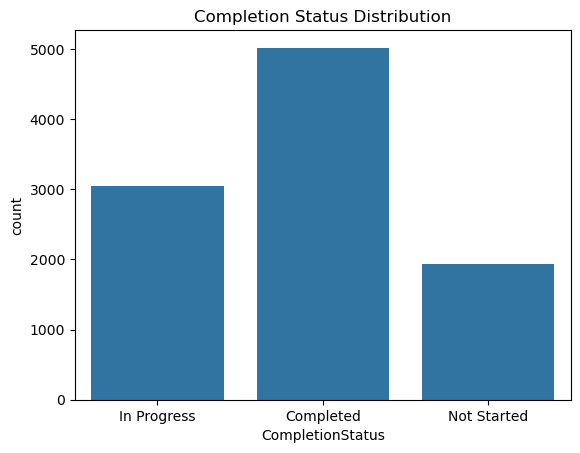

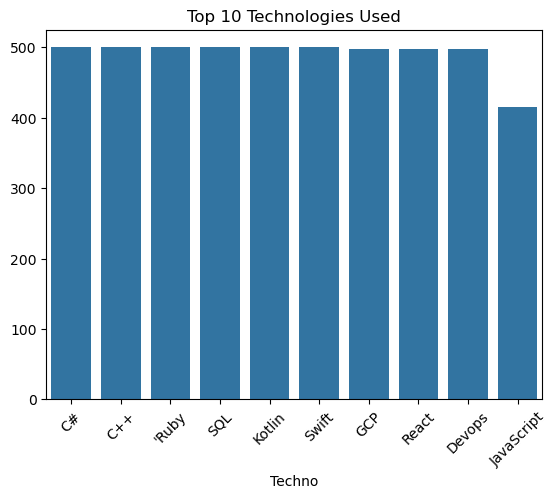

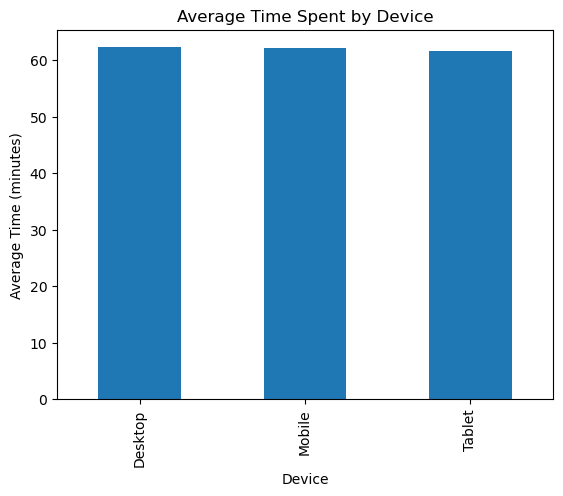

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Completion Status Distribution
sns.countplot(x='CompletionStatus', data=df)
plt.title('Completion Status Distribution')
plt.show()

# 2. Technology Usage Frequency
top_tech = df['Techno'].value_counts().head(10)
sns.barplot(x=top_tech.index, y=top_tech.values)
plt.xticks(rotation=45)
plt.title('Top 10 Technologies Used')
plt.show()

# 3. Average Time by Device
avg_time = df.groupby('Device')['Time_Spent'].mean().sort_values(ascending=False)
avg_time.plot(kind='bar', title='Average Time Spent by Device')
plt.ylabel('Average Time (minutes)')
plt.show()


['2024-12' '2024-05' '2025-01' '2024-09' '2025-03' '2024-06' '2024-11'
 '2024-07' '2024-10' '2025-02' '2025-04' '2024-08' '2024-04']


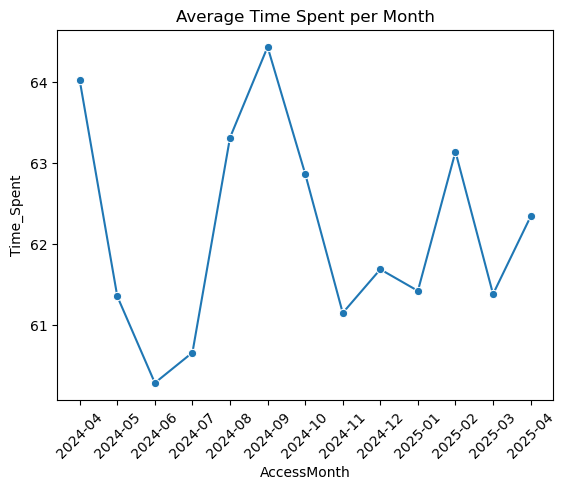

In [6]:
# Ensure AccessMonth column is correct format
print(df['AccessMonth'].unique())

month_trend = df.groupby('AccessMonth')['Time_Spent'].mean().reset_index()
sns.lineplot(x='AccessMonth', y='Time_Spent', data=month_trend, marker='o')
plt.title('Average Time Spent per Month')
plt.xticks(rotation=45)
plt.show()


In [7]:
view_df = pd.read_sql("SELECT * FROM LMS_Usage_Insights", conn)
print(view_df.head())
print(view_df.describe())

  Techno Country   Device AccessMonth  Total_Users  Avg_Time_Spent  Completed  \
0  'Ruby  Canada  Desktop     2024-05            5              56          4   
1  'Ruby  Canada  Desktop     2024-06            2              45          2   
2  'Ruby  Canada  Desktop     2024-07            2              66          1   
3  'Ruby  Canada  Desktop     2024-08            5              51          2   
4  'Ruby  Canada  Desktop     2024-09            3              75          1   

   In_Progress  Not_Started  
0            0            1  
1            0            0  
2            0            1  
3            3            0  
4            1            1  
       Total_Users  Avg_Time_Spent    Completed  In_Progress  Not_Started
count  4128.000000     4128.000000  4128.000000  4128.000000  4128.000000
mean      2.422481       61.938953     1.215359     0.738130     0.468992
std       1.459509       25.238588     1.059137     0.852869     0.664447
min       1.000000        5.000000   

C:\Users\varsh\AppData\Local\Temp\ipykernel_27560\2808783656.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  view_df = pd.read_sql("SELECT * FROM LMS_Usage_Insights", conn)


In [8]:
df.to_excel("LMS_Usage_Cleaned.xlsx", index=False)
view_df.to_excel("LMS_Usage_Insights.xlsx", index=False)
print("✅ Files exported successfully!")

✅ Files exported successfully!


In [14]:
df.to_excel(r"C:\DSEdify_LMS_Analytics\data\processed\LMS_Usage_Cleaned.xlsx", index=False)
view_df.to_excel(r"C:\DSEdify_LMS_Analytics\data\processed\LMS_Usage_Insights.xlsx", index=False)

NameError: name 'view_df' is not defined

Dataset Loaded ✅ (10000 records, 8 columns)
Fitting 5 folds for each of 12 candidates, totalling 60 fits
✅ Best Parameters: {'class_weight': 'balanced', 'max_depth': 15, 'min_samples_split': 5, 'n_estimators': 100}

🎯 Final Model Accuracy: 44.10%

Classification Report:
              precision    recall  f1-score   support

   Completed       0.52      0.68      0.59      1004
 In Progress       0.34      0.25      0.29       609
 Not Started       0.20      0.12      0.15       387

    accuracy                           0.44      2000
   macro avg       0.35      0.35      0.34      2000
weighted avg       0.40      0.44      0.41      2000



C:\Users\varsh\AppData\Local\Temp\ipykernel_24608\222818704.py:105: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=feat_imp, palette="viridis")
C:\Users\varsh\AppData\Local\Temp\ipykernel_24608\222818704.py:107: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\varsh\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


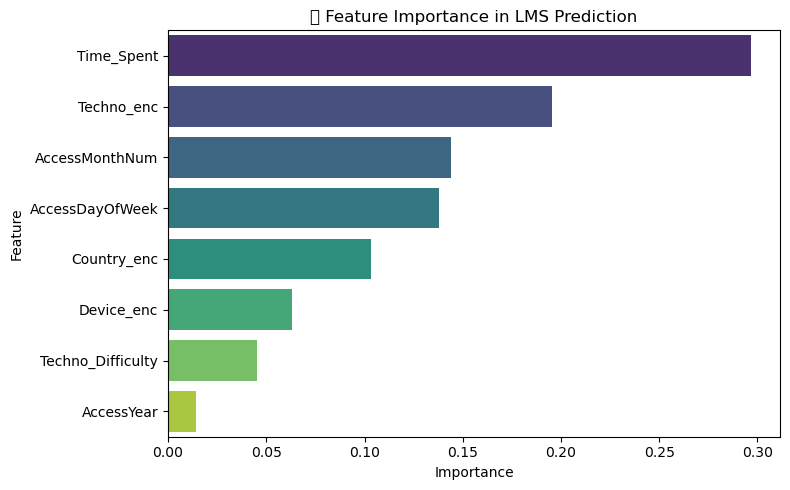


✅ Predictions saved to: C:\Users\varsh\lms_predictions_tableau_new.csv


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# -------------------------------
# 1️⃣ Load Data
# -------------------------------
df = pd.read_excel(r"C:\DSEdify_LMS_Analytics\data\processed\lms_usage_cleaned.xlsx")
print(f"Dataset Loaded ✅ ({df.shape[0]} records, {df.shape[1]} columns)")

# -------------------------------
# 2️⃣ Basic Cleaning
# -------------------------------
# Remove invalid or missing values
df = df.dropna(subset=["CompletionStatus", "Techno", "Device", "Country", "Time_Spent"])
df = df[df["Time_Spent"] >= 0]

# -------------------------------
# 3️⃣ Feature Engineering
# -------------------------------
# Create time-related features
df["AccessYear"] = df["AccessDate"].dt.year
df["AccessMonthNum"] = df["AccessDate"].dt.month
df["AccessDayOfWeek"] = df["AccessDate"].dt.dayofweek

# Tech Difficulty (example mapping)
difficulty_map = {
    "Python": 3, "Java": 4, "SQL": 2, "JavaScript": 3,
    "C++": 5, "HTML": 1, "CSS": 1, "React": 4, "Angular": 5
}
df["Techno_Difficulty"] = df["Techno"].map(difficulty_map).fillna(3)

# -------------------------------
# 4️⃣ Encode Categorical Features
# -------------------------------
le_tech = LabelEncoder()
le_device = LabelEncoder()
le_country = LabelEncoder()
le_target = LabelEncoder()

df["Techno_enc"] = le_tech.fit_transform(df["Techno"])
df["Device_enc"] = le_device.fit_transform(df["Device"])
df["Country_enc"] = le_country.fit_transform(df["Country"])
df["Target_enc"] = le_target.fit_transform(df["CompletionStatus"])

# -------------------------------
# 5️⃣ Define Features and Target
# -------------------------------
features = [
    "Techno_enc", "Device_enc", "Country_enc", "Time_Spent",
    "AccessYear", "AccessMonthNum", "AccessDayOfWeek", "Techno_Difficulty"
]
target = "Target_enc"

X = df[features]
y = df[target]

# -------------------------------
# 6️⃣ Train-Test Split
# -------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# -------------------------------
# 7️⃣ Train Model with Hyperparameter Tuning
# -------------------------------
param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [10, 15, 20],
    "min_samples_split": [5, 10],
    "class_weight": ["balanced"]
}

rf = RandomForestClassifier(random_state=42)
grid = GridSearchCV(rf, param_grid, scoring="accuracy", cv=5, n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

best_model = grid.best_estimator_
print(f"✅ Best Parameters: {grid.best_params_}")

# -------------------------------
# 8️⃣ Evaluate Model
# -------------------------------
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"\n🎯 Final Model Accuracy: {accuracy*100:.2f}%")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le_target.classes_))

# -------------------------------
# 9️⃣ Feature Importance Visualization
# -------------------------------
feat_imp = pd.DataFrame({
    "Feature": features,
    "Importance": best_model.feature_importances_
}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(x="Importance", y="Feature", data=feat_imp, palette="viridis")
plt.title("🔍 Feature Importance in LMS Prediction")
plt.tight_layout()
plt.show()

# -------------------------------
# 🔟 Generate Predictions for Full Dataset
# -------------------------------
df["Predicted_Status"] = le_target.inverse_transform(best_model.predict(X))
proba = best_model.predict_proba(X)
df["Pred_Prob_Completed"] = proba[:, 0]
df["Pred_Prob_In Progress"] = proba[:, 1]
df["Pred_Prob_Not Started"] = proba[:, 2]

# -------------------------------
# 11️⃣ Save Results for Tableau
# -------------------------------
save_path = r"C:\Users\varsh\lms_predictions_tableau_new.csv"
df.to_csv(save_path, index=False)
print(f"\n✅ Predictions saved to: {save_path}")


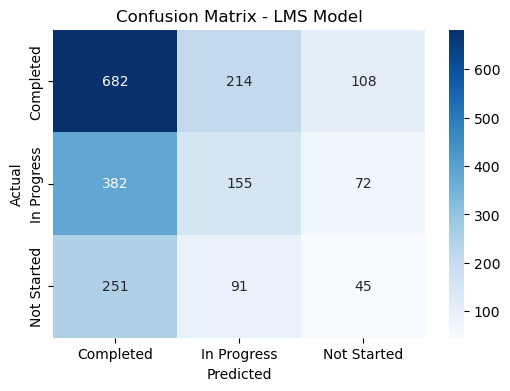

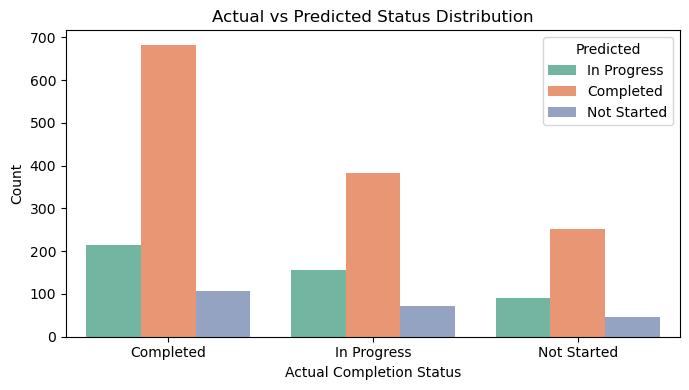

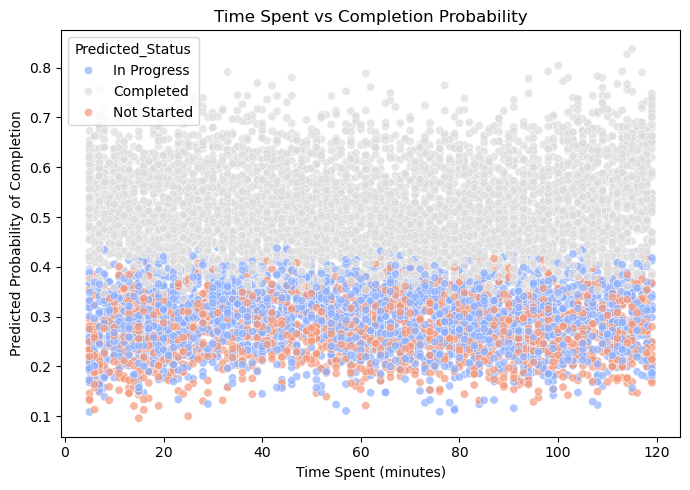

In [3]:
# ---------------------------------------
# 1️⃣ Confusion Matrix
# ---------------------------------------
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le_target.classes_,
            yticklabels=le_target.classes_)
plt.title("Confusion Matrix - LMS Model")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ---------------------------------------
# 2️⃣ Actual vs Predicted Comparison
# ---------------------------------------
comp = pd.DataFrame({
    "Actual": le_target.inverse_transform(y_test),
    "Predicted": le_target.inverse_transform(y_pred)
})

plt.figure(figsize=(7,4))
sns.countplot(data=comp, x="Actual", hue="Predicted", palette="Set2")
plt.title("Actual vs Predicted Status Distribution")
plt.xlabel("Actual Completion Status")
plt.ylabel("Count")
plt.legend(title="Predicted")
plt.tight_layout()
plt.show()

# ---------------------------------------
# 3️⃣ Time Spent vs Predicted Probability
# ---------------------------------------
plt.figure(figsize=(7,5))
sns.scatterplot(data=df, x="Time_Spent", y="Pred_Prob_Completed",
                hue="Predicted_Status", alpha=0.7, palette="coolwarm")
plt.title("Time Spent vs Completion Probability")
plt.xlabel("Time Spent (minutes)")
plt.ylabel("Predicted Probability of Completion")
plt.tight_layout()
plt.show()
